In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from utils import DogsDataset, preprocessing, data_augment

In [3]:
# 📂 Chargement des DataFrames sauvegardés
df_train = pd.read_pickle("df_train.pkl")
df_test = pd.read_pickle("df_test.pkl")

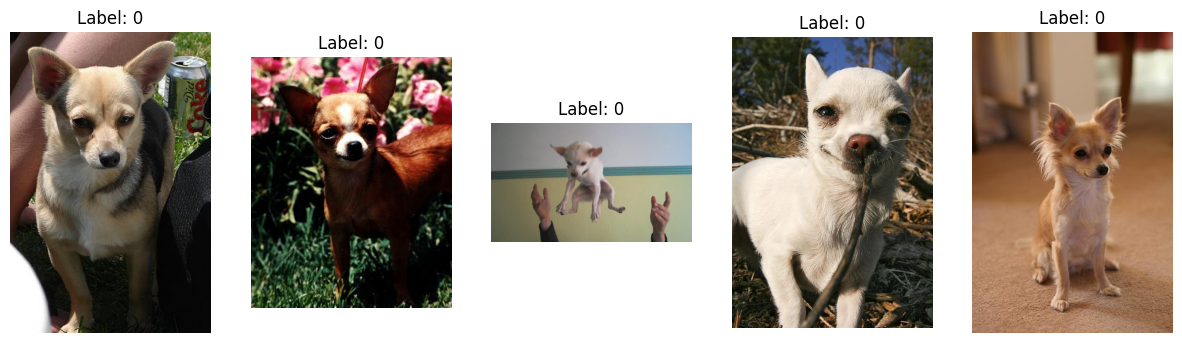

In [4]:
# ⚡ Création du dataset
dataset_train = DogsDataset(df_train)
dataset_test = DogsDataset(df_test)

# 📌 Affichage des 5 premières images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # 1 ligne, 5 colonnes

for i in range(5):
    img, label = dataset_train[i]  # Récupère image et label
    axes[i].imshow(img)  # Affichage avec Matplotlib
    axes[i].set_title(f"Label: {label}")  # Ajoute le label
    axes[i].axis("off")  # Cache les axes

plt.show()

In [5]:
dataset_preprocessing_train = DogsDataset(df_train, transforms=preprocessing)

In [6]:
dataset_preprocessing_train

In [7]:
dataset_preprocessing_test = DogsDataset(df_test, transforms=preprocessing)

In [8]:
dataset_augment_train = DogsDataset(df_train, transforms=data_augment)

In [9]:
dataset_augment_test = DogsDataset(df_test, transforms=data_augment)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(32 * 26 * 26, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, num_classes)  # ✅ Ajusté dynamiquement

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Pas de softmax ici, car inclus dans la loss
        return x


In [11]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# Assurez-vous que votre DataLoader est correctement configuré
train_loader = DataLoader(dataset_preprocessing_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_preprocessing_test, batch_size=32, shuffle=False)

In [12]:
import torch
import torch.optim as optim

device = 'cuda'

# Si tu n'as pas encore créé le modèle, voici un exemple d'initialisation
model = CustomCNN(num_classes=len(df_train["breed"].unique())).to(device)

# Définir la fonction de perte et l'optimiseur
criterion = torch.nn.CrossEntropyLoss()  # Fonction de perte pour la classification multi-classes
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [13]:
# Définir le nombre d'époques
num_epochs = 20

# Dossier de sauvegarde
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialisation
best_accuracy = -float('inf')  # ou float('inf') pour suivre la loss
best_epoch = -1

# Entraînement du modèle
for epoch in range(num_epochs):
    model.train()  # Met le modèle en mode entraînement
    train_loss = 0.0

    # Utilisation de tqdm pour afficher la barre de progression pendant l'entraînement
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for inputs, labels in tepoch:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  # Remet à zéro les gradients de l'optimiseur

            # Passage avant (forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calcul des gradients et mise à jour des poids
            loss.backward()
            optimizer.step()

            # Mise à jour de la barre de progression
            train_loss += loss.item()
            tepoch.set_postfix(loss=train_loss / (tepoch.n + 1))  # Afficher la moyenne des pertes

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss / len(train_loader):.4f}")

    # Validation du modèle après chaque époque
    model.eval()  # Met le modèle en mode évaluation
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul de gradients pendant la validation
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss / len(test_loader):.4f}, Accuracy: {val_accuracy:.2f}%")

    # Sauvegarde si le modèle est meilleur
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch + 1

        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pth"))
        print(f"✅ Nouveau meilleur modèle sauvegardé à l'epoch {best_epoch} (accuracy = {best_accuracy:.4f})")

# Info finale
print(f"\n✅ Meilleur modèle obtenu à l'epoch {best_epoch} avec accuracy = {best_accuracy:.4f}")


Epoch 1/20: 100%|██████████| 56/56 [00:07<00:00,  7.79batch/s, loss=2.27]


Epoch 1/20 - Training Loss: 2.2713
Validation Loss: 2.2562, Accuracy: 16.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 1 (accuracy = 16.0000)


Epoch 2/20: 100%|██████████| 56/56 [00:06<00:00,  8.34batch/s, loss=2.17]


Epoch 2/20 - Training Loss: 2.1684
Validation Loss: 2.1888, Accuracy: 19.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 2 (accuracy = 19.3333)


Epoch 3/20: 100%|██████████| 56/56 [00:06<00:00,  8.24batch/s, loss=2.07]


Epoch 3/20 - Training Loss: 2.0683
Validation Loss: 2.1215, Accuracy: 22.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 3 (accuracy = 22.6667)


Epoch 4/20: 100%|██████████| 56/56 [00:06<00:00,  8.12batch/s, loss=1.98]


Epoch 4/20 - Training Loss: 1.9760
Validation Loss: 2.0874, Accuracy: 22.00%


Epoch 5/20: 100%|██████████| 56/56 [00:06<00:00,  8.35batch/s, loss=1.9] 


Epoch 5/20 - Training Loss: 1.8986
Validation Loss: 2.0358, Accuracy: 23.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 5 (accuracy = 23.3333)


Epoch 6/20: 100%|██████████| 56/56 [00:06<00:00,  8.28batch/s, loss=1.83]


Epoch 6/20 - Training Loss: 1.8339
Validation Loss: 2.0052, Accuracy: 24.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 6 (accuracy = 24.0000)


Epoch 7/20: 100%|██████████| 56/56 [00:06<00:00,  8.17batch/s, loss=1.76]


Epoch 7/20 - Training Loss: 1.7636
Validation Loss: 1.9903, Accuracy: 29.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 7 (accuracy = 29.3333)


Epoch 8/20: 100%|██████████| 56/56 [00:06<00:00,  8.44batch/s, loss=1.69]


Epoch 8/20 - Training Loss: 1.6930
Validation Loss: 1.9510, Accuracy: 31.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 8 (accuracy = 31.3333)


Epoch 9/20: 100%|██████████| 56/56 [00:06<00:00,  8.55batch/s, loss=1.65]


Epoch 9/20 - Training Loss: 1.6463
Validation Loss: 1.9361, Accuracy: 26.67%


Epoch 10/20: 100%|██████████| 56/56 [00:06<00:00,  8.53batch/s, loss=1.59]


Epoch 10/20 - Training Loss: 1.5866
Validation Loss: 1.9186, Accuracy: 29.33%


Epoch 11/20: 100%|██████████| 56/56 [00:06<00:00,  8.58batch/s, loss=1.55]


Epoch 11/20 - Training Loss: 1.5535
Validation Loss: 1.8961, Accuracy: 31.33%


Epoch 12/20: 100%|██████████| 56/56 [00:06<00:00,  8.48batch/s, loss=1.51]


Epoch 12/20 - Training Loss: 1.5094
Validation Loss: 1.8979, Accuracy: 31.33%


Epoch 13/20: 100%|██████████| 56/56 [00:06<00:00,  8.56batch/s, loss=1.46]


Epoch 13/20 - Training Loss: 1.4571
Validation Loss: 1.8693, Accuracy: 32.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 13 (accuracy = 32.0000)


Epoch 14/20: 100%|██████████| 56/56 [00:06<00:00,  8.47batch/s, loss=1.41]


Epoch 14/20 - Training Loss: 1.4116
Validation Loss: 1.8547, Accuracy: 30.67%


Epoch 15/20: 100%|██████████| 56/56 [00:06<00:00,  8.50batch/s, loss=1.37]


Epoch 15/20 - Training Loss: 1.3705
Validation Loss: 1.8432, Accuracy: 32.00%


Epoch 16/20: 100%|██████████| 56/56 [00:06<00:00,  8.52batch/s, loss=1.33]


Epoch 16/20 - Training Loss: 1.3310
Validation Loss: 1.8347, Accuracy: 32.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 16 (accuracy = 32.6667)


Epoch 17/20: 100%|██████████| 56/56 [00:06<00:00,  8.50batch/s, loss=1.29]


Epoch 17/20 - Training Loss: 1.2917
Validation Loss: 1.8296, Accuracy: 33.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 17 (accuracy = 33.3333)


Epoch 18/20: 100%|██████████| 56/56 [00:06<00:00,  8.45batch/s, loss=1.26]


Epoch 18/20 - Training Loss: 1.2589
Validation Loss: 1.8226, Accuracy: 29.33%


Epoch 19/20: 100%|██████████| 56/56 [00:06<00:00,  8.60batch/s, loss=1.22]


Epoch 19/20 - Training Loss: 1.2152
Validation Loss: 1.8197, Accuracy: 32.00%


Epoch 20/20: 100%|██████████| 56/56 [00:06<00:00,  8.49batch/s, loss=1.19]


Epoch 20/20 - Training Loss: 1.1860
Validation Loss: 1.8250, Accuracy: 30.67%

✅ Meilleur modèle obtenu à l'epoch 17 avec accuracy = 33.3333


In [14]:
train_loader_augment = DataLoader(dataset_augment_train, batch_size=32, shuffle=True)
test_loader_augment = DataLoader(dataset_augment_test, batch_size=32, shuffle=False)

In [15]:
device = 'cuda'

# Si tu n'as pas encore créé le modèle, voici un exemple d'initialisation
model_augment = CustomCNN(num_classes=len(df_train["breed"].unique())).to(device)

# Définir la fonction de perte et l'optimiseur
criterion = torch.nn.CrossEntropyLoss()  # Fonction de perte pour la classification multi-classes
optimizer = optim.Adam(model_augment.parameters(), lr=1e-5)

In [16]:
# Définir le nombre d'époques
num_epochs = 20

# Dossier de sauvegarde
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialisation
best_accuracy = -float('inf')  # ou float('inf') pour suivre la loss
best_epoch = -1

# Entraînement du modèle
for epoch in range(num_epochs):
    model_augment.train()  # Met le modèle en mode entraînement
    train_loss = 0.0

    # Utilisation de tqdm pour afficher la barre de progression pendant l'entraînement
    with tqdm(train_loader_augment, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for inputs, labels in tepoch:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  # Remet à zéro les gradients de l'optimiseur

            # Passage avant (forward)
            outputs = model_augment(inputs)
            loss = criterion(outputs, labels)

            # Calcul des gradients et mise à jour des poids
            loss.backward()
            optimizer.step()

            # Mise à jour de la barre de progression
            train_loss += loss.item()
            tepoch.set_postfix(loss=train_loss / (tepoch.n + 1))  # Afficher la moyenne des pertes

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss / len(train_loader_augment):.4f}")

    # Validation du modèle après chaque époque
    model_augment.eval()  # Met le modèle en mode évaluation
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul de gradients pendant la validation
        for inputs, labels in test_loader_augment:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_augment(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss / len(test_loader_augment):.4f}, Accuracy: {val_accuracy:.2f}%")

    # Sauvegarde si le modèle est meilleur
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch + 1

        torch.save(model_augment.state_dict(), os.path.join(checkpoint_dir, "best_model_augment.pth"))
        print(f"✅ Nouveau meilleur modèle sauvegardé à l'epoch {best_epoch} (accuracy = {best_accuracy:.4f})")

# Info finale
print(f"\n✅ Meilleur modèle obtenu à l'epoch {best_epoch} avec accuracy = {best_accuracy:.4f}")


Epoch 1/20: 100%|██████████| 56/56 [00:07<00:00,  7.63batch/s, loss=2.27]


Epoch 1/20 - Training Loss: 2.2746
Validation Loss: 2.2642, Accuracy: 13.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 1 (accuracy = 13.3333)


Epoch 2/20: 100%|██████████| 56/56 [00:07<00:00,  7.66batch/s, loss=2.22]


Epoch 2/20 - Training Loss: 2.2168
Validation Loss: 2.2293, Accuracy: 12.67%


Epoch 3/20: 100%|██████████| 56/56 [00:07<00:00,  7.67batch/s, loss=2.16]


Epoch 3/20 - Training Loss: 2.1644
Validation Loss: 2.2100, Accuracy: 16.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 3 (accuracy = 16.6667)


Epoch 4/20: 100%|██████████| 56/56 [00:07<00:00,  7.66batch/s, loss=2.12]


Epoch 4/20 - Training Loss: 2.1198
Validation Loss: 2.1652, Accuracy: 20.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 4 (accuracy = 20.6667)


Epoch 5/20: 100%|██████████| 56/56 [00:07<00:00,  7.64batch/s, loss=2.07]


Epoch 5/20 - Training Loss: 2.0742
Validation Loss: 2.1300, Accuracy: 23.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 5 (accuracy = 23.3333)


Epoch 6/20: 100%|██████████| 56/56 [00:07<00:00,  7.69batch/s, loss=2.02]


Epoch 6/20 - Training Loss: 2.0210
Validation Loss: 2.0747, Accuracy: 28.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 6 (accuracy = 28.0000)


Epoch 7/20: 100%|██████████| 56/56 [00:07<00:00,  7.54batch/s, loss=1.98]


Epoch 7/20 - Training Loss: 1.9793
Validation Loss: 2.0862, Accuracy: 22.67%


Epoch 8/20: 100%|██████████| 56/56 [00:07<00:00,  7.59batch/s, loss=1.94]


Epoch 8/20 - Training Loss: 1.9447
Validation Loss: 2.0608, Accuracy: 27.33%


Epoch 9/20: 100%|██████████| 56/56 [00:07<00:00,  7.57batch/s, loss=1.92]


Epoch 9/20 - Training Loss: 1.9152
Validation Loss: 2.0117, Accuracy: 29.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 9 (accuracy = 29.3333)


Epoch 10/20: 100%|██████████| 56/56 [00:07<00:00,  7.67batch/s, loss=1.88]


Epoch 10/20 - Training Loss: 1.8798
Validation Loss: 2.0147, Accuracy: 31.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 10 (accuracy = 31.3333)


Epoch 11/20: 100%|██████████| 56/56 [00:07<00:00,  7.58batch/s, loss=1.85]


Epoch 11/20 - Training Loss: 1.8479
Validation Loss: 1.9985, Accuracy: 32.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 11 (accuracy = 32.6667)


Epoch 12/20: 100%|██████████| 56/56 [00:07<00:00,  7.63batch/s, loss=1.83]


Epoch 12/20 - Training Loss: 1.8319
Validation Loss: 1.9713, Accuracy: 32.67%


Epoch 13/20: 100%|██████████| 56/56 [00:07<00:00,  7.69batch/s, loss=1.8] 


Epoch 13/20 - Training Loss: 1.8000
Validation Loss: 1.9761, Accuracy: 31.33%


Epoch 14/20: 100%|██████████| 56/56 [00:07<00:00,  7.67batch/s, loss=1.79]


Epoch 14/20 - Training Loss: 1.7854
Validation Loss: 1.9562, Accuracy: 29.33%


Epoch 15/20: 100%|██████████| 56/56 [00:07<00:00,  7.68batch/s, loss=1.78]


Epoch 15/20 - Training Loss: 1.7753
Validation Loss: 1.9323, Accuracy: 33.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 15 (accuracy = 33.3333)


Epoch 16/20: 100%|██████████| 56/56 [00:07<00:00,  7.55batch/s, loss=1.76]


Epoch 16/20 - Training Loss: 1.7583
Validation Loss: 1.9280, Accuracy: 36.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 16 (accuracy = 36.0000)


Epoch 17/20: 100%|██████████| 56/56 [00:07<00:00,  7.65batch/s, loss=1.73]


Epoch 17/20 - Training Loss: 1.7330
Validation Loss: 1.9421, Accuracy: 32.00%


Epoch 18/20: 100%|██████████| 56/56 [00:07<00:00,  7.69batch/s, loss=1.72]


Epoch 18/20 - Training Loss: 1.7153
Validation Loss: 1.8858, Accuracy: 32.00%


Epoch 19/20: 100%|██████████| 56/56 [00:07<00:00,  7.68batch/s, loss=1.7] 


Epoch 19/20 - Training Loss: 1.6959
Validation Loss: 1.9285, Accuracy: 32.00%


Epoch 20/20: 100%|██████████| 56/56 [00:07<00:00,  7.65batch/s, loss=1.69]


Epoch 20/20 - Training Loss: 1.6926
Validation Loss: 1.9144, Accuracy: 36.00%

✅ Meilleur modèle obtenu à l'epoch 16 avec accuracy = 36.0000
